<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

# 1. SINDy (sparse identification of the non-linear dynamics) in Groud Truth Coordinates z

1.1 Simulation


In [2]:
# Define the pendulum_rhs function
def pendulum_rhs(z, dzdt, coefficients, terms):
    return np.dot(terms(z), coefficients)

In [3]:
# Define the pendulum_ode_step function
def pendulum_ode_step(y, t, coefficients, terms):
    D = len(y) // 2
    z_values = y[:D]
    dzdt_values = y[D:]

    # Evaluate rhs using the current terms
    rhs = pendulum_rhs(z_values, dzdt_values, coefficients, terms)

    # Check if rhs is 1-dimensional or 2-dimensional
    if np.ndim(rhs) == 1:
        dydt = np.concatenate([dzdt_values, rhs])
    else:
        dydt = np.concatenate([dzdt_values, rhs[1]])

    return dydt

In [4]:
# Function to simulate the pendulum using odeint
def simulate_pendulum(y0, coefficients, terms, T, dt):
    # Call odeint with the pendulum_ode_step function
    result = odeint(pendulum_ode_step, y0, np.arange(0, T, dt), args=(coefficients, terms))

    return result

(100, 2)
(100, 1)


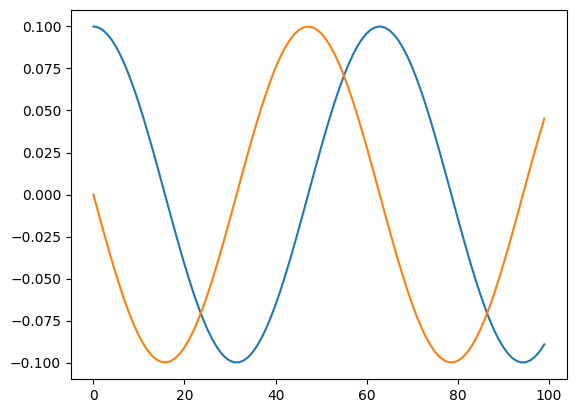

In [5]:
# checking whether the code is working so far
D = 1
L = 1
z0 = np.array([0.1])
dz0 = np.array([0.0])
coefficients = np.array([[-1.0]])

# Define terms as a vector of functions (sine function in this case)
terms = lambda z: np.sin(z)

T = 10.0
dt = 0.1
y0 = np.concatenate([z0, dz0])

result = simulate_pendulum(y0, coefficients, terms, T, dt)
plt.plot(result); print(np.shape(result)); print(np.shape(result[:,:D]))

yep. the code so far is working! let's proceed further.

In [6]:
def create_pendulum_data(z0_min, z0_max,
                         dz0_min, dz0_max,
                         coefficients, terms,
                         T, dt, N,
                         embedding=None, rejection=True, Dim=1):
    data_dict = {}

    for sim_run_num in tqdm(range(N), desc="Simulations"):
        while True:
            z0 = np.array([np.random.uniform(z0_min, z0_max)])
            dz0 = np.array([np.random.uniform(dz0_min, dz0_max)])

            if not rejection:
                break  # No rejection, proceed with the simulation

            angular_momentum = 0.5 * (dz0 ** 2) - np.cos(z0)
            #print("angular_momentum", np.abs(angular_momentum))

            if np.abs(angular_momentum) <= 0.99:
                break  # Angular momentum condition satisfied, proceed with the simulation

        simulation_result = simulate_pendulum(np.concatenate([z0, dz0]), coefficients, terms, T, dt)
        # D=np.shape(simulation_result)[1]//2
        # print("Dim is:", Dim)
        second_derivative = pendulum_rhs(simulation_result[:,:Dim], simulation_result[:,Dim:],
                                         coefficients, terms)

        if embedding is not None:
            # Add code for artificial embedding (needed later)
            pass

        data_dict[sim_run_num+1]={"z":simulation_result[:, :Dim],
                                  "dzdt":simulation_result[:, Dim:],
                                  "d2zdt":second_derivative}

        #data.append((simulation_result[:, :Dim], simulation_result[:, Dim:], second_derivative))#[D:]))

    return data_dict



Let's create the dataset {z , $\dot{z}$ , $\ddot{z}$}

In [7]:
z0_min = -np.pi
z0_max = np.pi
dz0_min = -2.1
dz0_max = 2.1
coefficients = np.array([[-1.0]])
terms_true = lambda z: np.sin(z)

T = 50.0
dt = 0.02
N =  100# number of simulation runs
embedding = None
rejection = True

training_data_dict = create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max,
                                     coefficients, terms_true, T, dt, N, embedding, rejection)

time=np.arange(0,T,step=dt)

# print("training_data dict:")
# print(training_data_dict)

Simulations: 100%|██████████| 100/100 [00:01<00:00, 69.72it/s]


Let's pick 5 simulations randomly and visualise {z , $\dot{z}$ , $\ddot{z}$}.

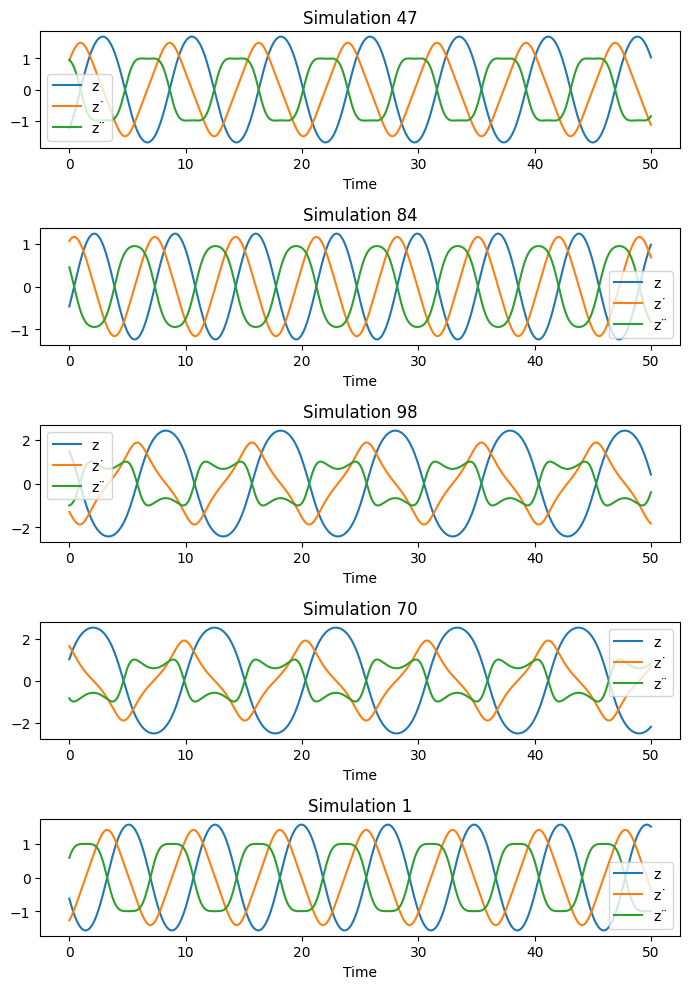

In [8]:
import matplotlib.pyplot as plt

# Choose 5 simulations randomly
selected_simulations = np.random.choice(N, 5, replace=False)

# Plot the selected simulations
fig, axs = plt.subplots(5, 1, figsize=(7, 10))

for i, sim_num in enumerate(selected_simulations):
    time_points = np.arange(0, T, step=dt)  # Assuming 'time' is not included in data_dict
    z_values = training_data_dict[sim_num+1]['z']  # zt
    dzdt_values = training_data_dict[sim_num+1]['dzdt']  # z˙t
    d2zdt_values = training_data_dict[sim_num+1]['d2zdt']  # z¨t

    # Plot z, z˙, and z¨ on the same plot
    axs[i].plot(time_points, z_values, label='z')
    axs[i].plot(time_points, dzdt_values, label='z˙')
    axs[i].plot(time_points, d2zdt_values, label='z¨')
    axs[i].set_title(f'Simulation {sim_num + 1}')
    axs[i].set_xlabel('Time')
    axs[i].legend()

plt.tight_layout()
plt.show()




Next step is to create the training data-set for the regression task.

In [9]:
# Extract arrays for "z", "dzdt", and "d2zdt"
z_arrays = [v["z"] for v in training_data_dict.values()]
dzdt_arrays = [v["dzdt"] for v in training_data_dict.values()]
d2zdt_arrays = [v["d2zdt"] for v in training_data_dict.values()]

# print(z_arrays)

# Concatenate along the first axis
concatenated_z = np.concatenate(z_arrays, axis=0)
concatenated_dzdt = np.concatenate(dzdt_arrays, axis=0)
concatenated_d2zdt = np.concatenate(d2zdt_arrays, axis=0)


print("Concatenated z:")
print(concatenated_z.shape) # number of datapoints (T*N,1)

Concatenated z:
(250000, 1)


In [66]:
z_diff_init_cond= np.concatenate(z_arrays, axis=1)
dzdt_diff_init_cond= np.concatenate(dzdt_arrays, axis=1)
d2zdt_diff_init_cond= np.concatenate(d2zdt_arrays, axis=1)
z_diff_init_cond

array([[-0.62749506, -0.84930783, -0.25651138, ...,  1.48529262,
         1.1743046 , -0.36788489],
       [-0.65286342, -0.88421373, -0.27597646, ...,  1.45931266,
         1.17857586, -0.35620971],
       [-0.67798884, -0.91881031, -0.29533258, ...,  1.4329352 ,
         1.1824775 , -0.34439501],
       ...,
       [ 1.52518384, -0.1606368 , -0.43685918, ...,  0.48082342,
         0.37195175, -0.47548368],
       [ 1.51878149, -0.12200253, -0.41855592, ...,  0.44459964,
         0.3505215 , -0.48536338],
       [ 1.51197968, -0.08331959, -0.40009009, ...,  0.40820385,
         0.32895391, -0.49505648]])

In [61]:
### recall that T=50, dt=0.02 and N=100
z_diff_init_cond.shape# this means data in i'th column correspond to i'th simualtion

(2500, 100)

1.2 Implementation and Training

In [10]:
### Based on our prior knowledge, defining our library matrix
def sin_term(z):
    return np.sin(z)

def cos_term(z):
    return np.cos(z)

def square(z):
  return z*z

def z_times_dzdt(z,dzdt):
  return z * dzdt


def term_vector(z,dzdt):
  to_return= np.array([np.ones(np.shape(z)), z, dzdt, sin_term(z),
                   square(z), z_times_dzdt(z,dzdt),
                   z*sin_term(z), square(dzdt),
                   dzdt * sin_term(z),
                   sin_term(z)*sin_term(z)
                   ])

  return to_return

For the regression task, $\mathbf{y}$ is $\ddot{z}$. Let's create our X dataset-library matrix.

In [11]:
# Creating the X matrix for the lasso regression

flattened_z = concatenated_z.flatten()
flattened_dzdt = concatenated_dzdt.flatten()

result = term_vector(flattened_z, flattened_dzdt)
# right now our X matrix (for Lasso) is of the shape (number of features X number of datapoints)
# let transpose it so that the shape of X matrix (for lasso) is (number of datapoints X no. of features)
X_for_regression=np.transpose(result)
print("X for regression is:")
print(X_for_regression); print(X_for_regression.shape); print(concatenated_z.shape)

X for regression is:
[[ 1.         -0.62749506 -1.27435791 ...  1.6239881   0.74819955
   0.34470854]
 [ 1.         -0.65286342 -1.26241115 ...  1.59368191  0.76686862
   0.36901183]
 [ 1.         -0.67798884 -1.25006323 ...  1.56265808  0.78407458
   0.39341488]
 ...
 [ 1.         -0.47548368 -0.49859205 ...  0.24859404  0.22823975
   0.20955203]
 [ 1.         -0.48536338 -0.48934872 ...  0.23946217  0.22829576
   0.21765006]
 [ 1.         -0.49505648 -0.47993226 ...  0.23033497  0.22800686
   0.22570229]]
(250000, 10)
(250000, 1)


Creating the trainig and test dataset and dataloaders

In [12]:
# creating training and the test set
X_train, X_test, y_train, y_test = train_test_split(X_for_regression,concatenated_d2zdt,
                                                    test_size=0.3,random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((175000, 10), (75000, 10), (175000, 1), (75000, 1))

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDataset for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Set batch size for training and test DataLoader
batch_size = 32

# Create DataLoader for training set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for test set
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Implementing SINDy using sklearn's LASSO

In [15]:
### checking the weights using the lasso regression
from sklearn.linear_model import Lasso

# Create Lasso model
lasso = Lasso(alpha=0.001, fit_intercept=False)

# Fit the model
lasso.fit(X_train, y_train)

# Access coefficients and intercept
coefficients = lasso.coef_
# intercept = lasso.intercept_

print("Coefficients:", coefficients)
# print("Intercept:", intercept)

Coefficients: [-0.         -0.00236992  0.         -0.99421595 -0.         -0.
 -0.         -0.         -0.         -0.        ]


As can be seen that coefficient corresponsing to sin(z) term is almost equal to -1. The other non-zero coefficient corresponds to the z term. It kinda makes sense because some points in our data belong to the initial points where small-angle approximation is valid.

In [16]:
### making predictions on the test dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = lasso.predict(X_test)

# Evaluate the performance using different metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 3.6039105069557455e-06
Mean Absolute Error (MAE): 0.0016874121709953974
R-squared (R2) Score: 0.999993349672689


* Let's implement the pytorch based `SINDy` regression

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [18]:
class SINDy(nn.Module):
    def __init__(self, input_size, output_size):
        super(SINDy, self).__init__()

        # Coefficient mask (boolean)
        self.mask = nn.Parameter(torch.ones(output_size, input_size,
                                            dtype=torch.bool), requires_grad=False)

        # Coefficient matrix
        self.coefficients = nn.Parameter(torch.ones(output_size, input_size,
                                                    dtype=torch.float32), requires_grad=True)

    def forward(self, x):
        # Apply boolean mask
        masked_coefficients = self.coefficients * self.mask.int().float()#self.mask

        # Linear combination of terms
        output = F.linear(x, masked_coefficients)

        return output

In [19]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# train and validate function without any thresholding
def train_and_validate_sindy(model, train_loader, val_loader,
                             num_epochs=100, print_epoch=1,
                             learning_rate=0.001):
    # Define optimizer and criterion inside the function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Lists to store average epoch losses for training and validation
    avg_epoch_train_losses = []
    avg_epoch_val_losses = []

    # List to store coefficient values over time
    coefficient_values_over_time = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)

        # Log average epoch losses
        avg_epoch_train_losses.append(avg_train_loss)
        avg_epoch_val_losses.append(avg_val_loss)

        # Log coefficient values
        #print("coefficients right now:")
        coefficients_snapshot = model.coefficients.detach().clone().numpy()
        #print(coefficients_snapshot)
        coefficient_values_over_time.append(coefficients_snapshot)

        # Print average epoch losses after print_epoch number of epochs
        if epoch % print_epoch == 0:
            print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')

    return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time


In [21]:
def plot_train_and_val_loss(train_loss, val_loss, want_logscale=True):
  plt.plot(train_loss,"-",label="train loss")
  plt.plot(val_loss, ":", label="val loss")
  plt.xlabel("epochs")
  plt.ylabel("average epoch loss")
  if want_logscale:
    plt.yscale('log')
  plt.legend()

In [22]:
# training the model
input_size = 10
output_size = 1

# Create SINDy model
sindy_model = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time = train_and_validate_sindy(sindy_model,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005)


Epoch 1/10, Avg. Training Loss: 7.145138865545893, Avg. Validation Loss: 0.029029500341351197
Epoch 2/10, Avg. Training Loss: 0.01103772371869514, Avg. Validation Loss: 0.00012189413293725401
Epoch 3/10, Avg. Training Loss: 6.856024002548279e-06, Avg. Validation Loss: 3.200017343743467e-10
Epoch 4/10, Avg. Training Loss: 1.9991595839746947e-11, Avg. Validation Loss: 1.774854542896983e-25
Epoch 5/10, Avg. Training Loss: 7.496635276256414e-08, Avg. Validation Loss: 2.501386495072042e-10
Epoch 6/10, Avg. Training Loss: 5.995960662435036e-08, Avg. Validation Loss: 1.5035116127281922e-13
Epoch 7/10, Avg. Training Loss: 6.481364830517188e-08, Avg. Validation Loss: 9.743766283293367e-15
Epoch 8/10, Avg. Training Loss: 5.277379581830889e-08, Avg. Validation Loss: 3.3319619075199325e-08
Epoch 9/10, Avg. Training Loss: 6.578944110016069e-08, Avg. Validation Loss: 3.2110330661200343e-11
Epoch 10/10, Avg. Training Loss: 9.780206637054055e-08, Avg. Validation Loss: 4.83567069033216e-16


In [23]:
# coefficient_values_over_time

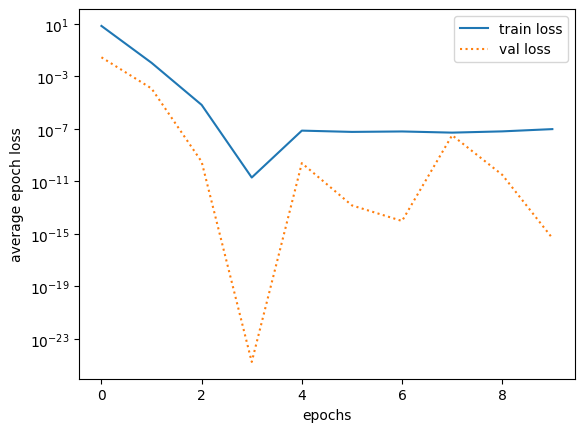

In [24]:
plot_train_and_val_loss(avg_epoch_train_losses,
                        avg_epoch_val_losses
                        )

In [25]:
# Accessing all model parameters (including coefficients)
all_parameters = list(sindy_model.parameters())

# Accessing the coefficient matrix (excluding the boolean mask)
coefficients_matrix = all_parameters[1].detach().numpy()

# Accessing the boolean mask
boolean_mask = sindy_model.mask.detach().numpy()

# Printing the results
#print("All Parameters (including coefficients):", all_parameters)
print("Coefficients:", coefficients_matrix)
print("Boolean Mask:", boolean_mask)

Coefficients: [[-2.0944595e-09 -7.8420195e-09  3.3674468e-09 -1.0000000e+00
  -4.4619783e-09 -8.8385610e-09  1.0620311e-08  2.9591729e-10
  -7.7099234e-09  5.8035377e-09]]
Boolean Mask: [[ True  True  True  True  True  True  True  True  True  True]]


1.3. Implementing the thresholding

In [26]:
def sequential_thresholding(coefficients, mask, epoch, threshold_a, interval):
    # Apply thresholding every 'interval' epochs
    # if interval > 0 and (epoch % interval == 0):
    # Identify small coefficients
    small_coefficients = torch.abs(coefficients) < threshold_a

    # Zero out small coefficients
    with torch.no_grad():
        # Zero out small coefficients
        coefficients[small_coefficients] = 0.0

    # Update the mask for coefficients smaller than a
    mask[small_coefficients] = False

    # # Set requires_grad to False for zeroed-out coefficients
    # coefficients[coefficients == 0.0].requires_grad_(False)

In [27]:
def PTA_thresholding(coefficients, mask,
                     epoch, threshold_a, threshold_b,
                     patience_p, E_a, E_b, previous_coefficients):


    #print("inside function coefficients are:"); print(coefficients)
    #print("inside function previous coefficients are:"); print(previous_coefficients)
    ## Identify coefficients exceeding thresholds
    coefficients_exceeding_a = torch.abs(coefficients) > threshold_a
    coefficients_exceeding_b = torch.abs(coefficients - previous_coefficients) > threshold_b

    #print("inside function abs(prev-now):"); print(torch.abs(coefficients - previous_coefficients))

    ## Update exceeded threshold epochs
    E_a[coefficients_exceeding_a] = epoch
    E_b[coefficients_exceeding_b] = epoch
    #print("E_a now inside fn:"); print(E_a)
    #print("E_b now inside fn:"); print(E_b)

    ## Element-wise OR to create Υ˜
    mask_tilde = ((epoch - E_a) < patience_p) | ((epoch - E_b) < patience_p)
    #print("mask_tilde is:"); print(mask_tilde)

    ## Update the coefficient mask
    #print("old mask is:");print(mask)
    new_mask = mask & mask_tilde
    # Update the original model.mask tensor in-place
    #print("new mask would have been:"); print(new_mask)

    locations_false = ~new_mask
    ## print("locations_false:", locations_false)
    mask[locations_false] = False
    #mask.masked_scatter_(mask_tilde, new_mask)
    #print("now mask is:"); print(mask)

    ## Clone the coefficients for the next epoch
    previous_coefficients = coefficients.clone().detach()# This ensures that the previous_coefficients tensor is detached from the computation graph
    return previous_coefficients

In [28]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader

# def train_and_validate_sindy(model, train_loader, val_loader,
#                              num_epochs=100, print_epoch=1,
#                              learning_rate=0.001, thresholding=None, threshold_a=1e-7, interval=10):

#     print("interval value is:", interval)
#     # Define optimizer and criterion inside the function
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     criterion = nn.MSELoss()

#     # Lists to store average epoch losses for training and validation
#     avg_epoch_train_losses = []
#     avg_epoch_val_losses = []

#     # List to store coefficient values over time
#     coefficient_values_over_time = []

#     for epoch in range(1, num_epochs + 1):
#         model.train()
#         train_loss = 0.0

#         for inputs, targets in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#         # Average training loss for the epoch
#         avg_train_loss = train_loss / len(train_loader)

#         # Validation
#         model.eval()
#         val_loss = 0.0

#         with torch.no_grad():
#             for inputs, targets in val_loader:
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 val_loss += loss.item()

#         # Average validation loss for the epoch
#         avg_val_loss = val_loss / len(val_loader)

#         # Log average epoch losses
#         avg_epoch_train_losses.append(avg_train_loss)
#         avg_epoch_val_losses.append(avg_val_loss)

#         # Apply Sequential Thresholding (ST) if specified
#         if thresholding == "sequential":
#             print(f"epoch % interval is: {epoch % interval}")
#             if (epoch % interval == 0):
#               print("now coefficients will be set to zero")
#               sequential_thresholding(model.coefficients, model.mask, epoch, threshold_a, interval)

#         # Log coefficient values
#         print("coefficients right now:")
#         coefficients_snapshot = model.coefficients.detach().clone().numpy()
#         print((model.coefficients.detach().clone() * model.mask.detach().int().float()).numpy())
#         print("boolean matrix:")
#         print(model.mask.detach().numpy())
#         coefficient_values_over_time.append(coefficients_snapshot)


#         # Print average epoch losses after print_epoch number of epochs
#         if epoch % print_epoch == 0:
#             print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')

#     return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time

In [29]:
# # training the model with sequential thresholding
# input_size = 10
# output_size = 1

# # Create SINDy model
# sindy_model_ST = SINDy(input_size, output_size)


# # Assuming sindy_model, train_loader, and test_loader are already defined
# avg_epoch_train_losses_ST, avg_epoch_val_losses_ST, coefficient_values_over_time_ST = train_and_validate_sindy(sindy_model_ST,
#                                                                                                       train_loader,
#                                                                                                       test_loader,
#                                                                                                       num_epochs=10,
#                                                                                                       learning_rate=0.0005,
#                                                                                                       thresholding="sequential",
#                                                                                                       threshold_a=0.00001,
#                                                                                                       interval=2)


In [30]:
# # Accessing all model parameters (including coefficients)
# all_parameters_ST = list(sindy_model_ST.parameters())

# # Accessing the coefficient matrix (excluding the boolean mask)
# coefficients_matrix_ST = all_parameters_ST[1].detach().numpy()

# # Accessing the boolean mask
# boolean_mask_ST = sindy_model_ST.mask.detach().numpy()

# # Printing the results
# #print("All Parameters (including coefficients):", all_parameters)
# print("Coefficients:", coefficients_matrix_ST)
# print("Boolean Mask:", boolean_mask_ST)

~TO DO:~ DONE BELOW:

~1. oh now I understand, I need to mask the coefficients and then use them! oh this makes sense. I get it now~.

~2. Implement PTAT.~

Patient Trend-Aware (PTA) Thresholding

In [31]:
# def PTA_thresholding(coefficients, mask,
#                      epoch, threshold_a, threshold_b,
#                      paitence_p, E_a, E_b, previous_coefficients):

#     # Identify small coefficients
#     coefficients_exceeding_a = torch.abs(coefficients) > threshold_a
#     coefficients_exceeding_b = torch.abs(coefficients-previous_coefficients) > threshold_b

#     # Zero out small coefficients
#     with torch.no_grad():
#         # Zero out small coefficients
#         E_a[coefficients_exceeding_a] = epoch
#         E_b[coefficients_exceeding_b] = epoch

#     e_times_identity= torch.full_like(E_a, epoch)
#     mask_tilde= torch.logical_or( ((e_times_identity-E_a) < paitence_p),
#                                     ((e_times_identity-E_b) < paitence_p)
#                                   )

#     ## update the mask for coefficients
#     mask = torch.logical_and(mask, mask_tilde)

#     ## update the previous coefficients for the next epoch
#     previous_coefficients = coefficients.copy()


#     return coefficients, mask, previous_coefficients

In [32]:
# def checking_sth(tensor_in):
#   tensor_in+=1

# # Create a sample tensor with a specific shape
# sample_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]])
# checking_sth(sample_tensor)
# print(sample_tensor)

In [33]:
# def add_1000(coeffs):
#   with torch.no_grad():
#     coeffs += 1000 # this is doing in-place changes in the tensor

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_and_validate_sindy(model, train_loader, val_loader,
                             num_epochs=100, print_epoch=1,
                             learning_rate=0.001, thresholding=None, threshold_a=1e-3,interval=10,
                             threshold_b=1e-4, patience_p=4):

    print("interval value is:", interval)
    # Define optimizer and criterion inside the function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Lists to store average epoch losses for training and validation
    avg_epoch_train_losses = []
    avg_epoch_val_losses = []

    # List to store coefficient values over time
    coefficient_values_over_time = []

    ### initialising some additional params if thresholding is "paitence"
    if thresholding == "patient":
      E_a= torch.zeros_like(model.coefficients)
      E_b= torch.zeros_like(model.coefficients)
      previous_coefficients = torch.zeros_like(model.coefficients)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)

        # Log average epoch losses
        avg_epoch_train_losses.append(avg_train_loss)
        avg_epoch_val_losses.append(avg_val_loss)

        # Apply Sequential Thresholding (ST) if specified
        if thresholding == "sequential":
            print(f"epoch % interval is: {epoch % interval}")
            if (epoch % interval == 0):
              print("----applying ST----")
              sequential_thresholding(model.coefficients, model.mask, epoch, threshold_a, interval)

        if thresholding == "patient":
            print("---applying PTAT -----")
            #* self.mask.int().float()
            #add_1000(model.coefficients)
            previous_coefficients= PTA_thresholding(model.coefficients #* model.mask.int().float()
                      , model.mask,
                     epoch, threshold_a, threshold_b,
                     patience_p, E_a, E_b, previous_coefficients)

            #print("-------------------outside the  PTAT function right now:-----------------")

        # print("E_a now is:"); print(E_a)
        # print("E_b now is:"); print(E_b)
        # print("previous_coefficients is:"); print(previous_coefficients)


        # Log coefficient values
        #print("coefficients right now:")
        coefficients_snapshot = model.coefficients.detach().clone().numpy()
        #print(coefficients_snapshot)
        #print("masked coefficients:")
        #print((model.coefficients.detach().clone() * model.mask.detach().int().float()).numpy())
        #print("boolean matrix:")
        #print(model.mask.detach().numpy())
        coefficient_values_over_time.append((model.coefficients.detach().clone() * model.mask.detach().int().float()).numpy().flatten())


        # Print average epoch losses after print_epoch number of epochs
        if epoch % print_epoch == 0:
            print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')
            print("_"*50)
    return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time

Let's train models with different thresholding schemes:

Sequential Thresholding

In [35]:
# training the model with sequential thresholding
input_size = 10
output_size = 1

# Create SINDy model
sindy_model_ST = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses_ST, avg_epoch_val_losses_ST, coefficient_values_over_time_ST = train_and_validate_sindy(sindy_model_ST,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005,
                                                                                                      thresholding="sequential",
                                                                                                      threshold_a=0.00001,
                                                                                                      interval=2)


interval value is: 2
epoch % interval is: 1
Epoch 1/10, Avg. Training Loss: 7.129254512614517, Avg. Validation Loss: 0.028296622731754678
__________________________________________________
epoch % interval is: 0
----applying ST----
Epoch 2/10, Avg. Training Loss: 0.010736179762752434, Avg. Validation Loss: 0.00011406358964400526
__________________________________________________
epoch % interval is: 1
Epoch 3/10, Avg. Training Loss: 6.384344935694078e-06, Avg. Validation Loss: 3.2462634760818495e-10
__________________________________________________
epoch % interval is: 0
----applying ST----
Epoch 4/10, Avg. Training Loss: 1.9987762481387594e-11, Avg. Validation Loss: 6.763352010365699e-25
__________________________________________________
epoch % interval is: 1
Epoch 5/10, Avg. Training Loss: 0.0, Avg. Validation Loss: 0.0
__________________________________________________
epoch % interval is: 0
----applying ST----
Epoch 6/10, Avg. Training Loss: 0.0, Avg. Validation Loss: 0.0
_______

In [36]:
# Accessing all model parameters (including coefficients)
all_parameters_ST = list(sindy_model_ST.parameters())

# Accessing the coefficient matrix (excluding the boolean mask)
coefficients_matrix_ST = all_parameters_ST[1].detach().numpy()

# Accessing the boolean mask
boolean_mask_ST = sindy_model_ST.mask.detach().numpy()

# Printing the results
#print("All Parameters (including coefficients):", all_parameters)
print("Coefficients:", coefficients_matrix_ST)
print("Boolean Mask:", boolean_mask_ST)

Coefficients: [[ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]]
Boolean Mask: [[False False False  True False False False False False False]]


Plotting coefficient history for SINDy with ST

Text(0.5, 1.0, 'SINDY with ST')

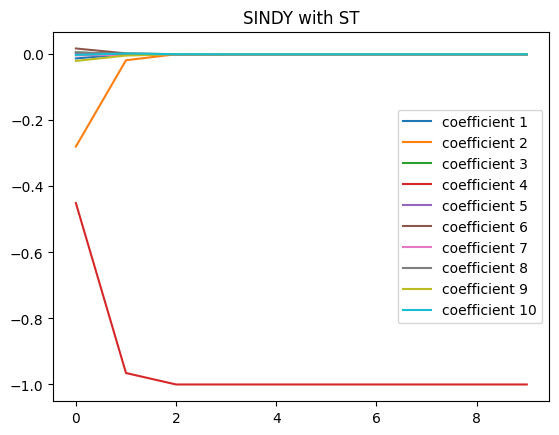

In [37]:
coefficient_array_ST= np.array(coefficient_values_over_time_ST)
for i in range(0,10):
    plt.plot(coefficient_array_ST[:,i], label=f"coefficient {i+1}")
plt.legend()
plt.title("SINDY with ST")

PTAT Thresholding

In [38]:
# training the model with PTAT thresholding
input_size = 10
output_size = 1

# Create SINDy model
sindy_model_PTAT = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses_ptat, avg_epoch_val_losses_ptat, coefficient_values_over_time_ptat = train_and_validate_sindy(sindy_model_PTAT,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005,
                                                                                                      thresholding="patient",
                                                                                                      threshold_a=0.001,
                                                                                                      threshold_b=0.0001,
                                                                                                      patience_p=2)


interval value is: 10
---applying PTAT -----
Epoch 1/10, Avg. Training Loss: 7.183604908638788, Avg. Validation Loss: 0.028631371889762426
__________________________________________________
---applying PTAT -----
Epoch 2/10, Avg. Training Loss: 0.010836126618715879, Avg. Validation Loss: 0.0001166474249601894
__________________________________________________
---applying PTAT -----
Epoch 3/10, Avg. Training Loss: 6.49229906211358e-06, Avg. Validation Loss: 4.069538778238637e-10
__________________________________________________
---applying PTAT -----
Epoch 4/10, Avg. Training Loss: 2.6634302460819112e-11, Avg. Validation Loss: 1.6689044385966347e-26
__________________________________________________
---applying PTAT -----
Epoch 5/10, Avg. Training Loss: 6.370968570912247e-08, Avg. Validation Loss: 6.518453602052482e-16
__________________________________________________
---applying PTAT -----
Epoch 6/10, Avg. Training Loss: 8.729125993578667e-19, Avg. Validation Loss: 0.0
______________

In [39]:
coefficient_array_ptat= np.array(coefficient_values_over_time_ptat)

Plotting coefficients obtained for SINDy with PTAT:

Text(0.5, 1.0, 'SINDy with PTAT')

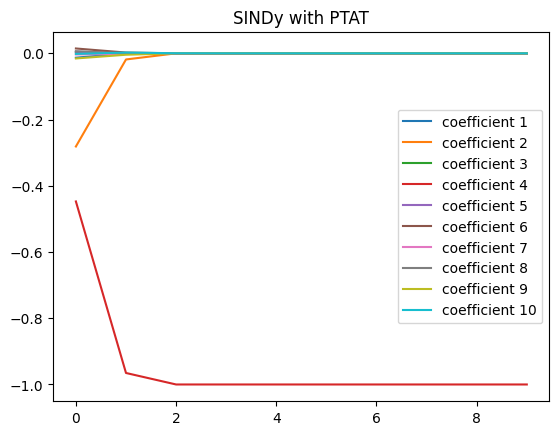

In [40]:
for i in range(0,10):
    plt.plot(coefficient_array_ptat[:,i], label=f"coefficient {i+1}")
plt.legend()
plt.title("SINDy with PTAT")

In [41]:
# threshold_a=1e-3,interval=10,
#                              threshold_b=1e-4, patience_p=4

### 2. SINDy-Autoencoder

2.1 Cartesian Embedding:

In [42]:
def cartesian_embedding(z_in, dzdt_in, d2zdt_in):

  ## x
  #print("____ x ____")
  x1=np.sin(z_in)
  x2= -np.cos(z_in)
  x=np.concatenate([x1,x2],axis=1)
  # print(x1); print(x2)
  # print(x)

  ## dxdt
  #print("____ dxdt ____")
  x1_dot= np.cos(z_in)* dzdt_in
  x2_dot= np.sin(z_in)* dzdt_in
  xdot= np.concatenate([x1_dot, x2_dot], axis=1)
  # print(x1_dot); print(x2_dot)
  # print(xdot)

  ## d2zdt
  #print("____ d2xdt ____")
  x1_ddot= -np.sin(z_in)* (dzdt_in*dzdt_in) + np.cos(z_in)* d2zdt_in
  x2_ddot = np.cos(z_in)* (dzdt_in*dzdt_in) + np.sin(z_in)* d2zdt_in
  xddot= np.concatenate([x1_ddot, x2_ddot], axis=1)
  # print(x1_ddot); print(x2_ddot)
  # print(xddot)

  return x, xdot, xddot


In [53]:
# creating the data in x domain.
x,xdot,xddot=cartesian_embedding(concatenated_z,concatenated_dzdt,concatenated_d2zdt)

let's create the train and test dataset and dataloaders for this training set

In [44]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# defining the custom dataset
class CustomDataset_simple_AE(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [45]:
# Split the dataset into train and test sets
cart_x_train, cart_x_test = train_test_split(x, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
cart_x_train_tensor = torch.Tensor(cart_x_train)
cart_x_test_tensor = torch.Tensor(cart_x_test)

# Create custom datasets and dataloaders
batch_size = 64

# Training dataset and dataloader
train_dataset = CustomDataset_simple_AE(cart_x_train_tensor)
cartesian_x_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing dataset and dataloader
test_dataset = CustomDataset_simple_AE(cart_x_test_tensor)
cartesian_x_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2.2 Autoencoder and hyperparameter optimization

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [47]:
# simple Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_size, num_layers,hidden_size):
        super(Autoencoder, self).__init__()

        # Encoder layers
        encoder_layers = [nn.Linear(input_size, hidden_size[0]), nn.Sigmoid()]
        for i in range(1, num_layers):
            encoder_layers.append(nn.Linear(hidden_size[i-1], hidden_size[i]))
            encoder_layers.append(nn.Sigmoid())
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = []
        for i in range(1,num_layers,1):
            decoder_layers.append(nn.Linear(hidden_size[-i], hidden_size[-i-1]))
            decoder_layers.append(nn.Sigmoid())
        decoder_layers.append(nn.Linear(hidden_size[-num_layers], input_size))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [48]:
# 2. train_and_validate_simple_AE() function
def train_and_validate_simple_AE(model, train_dataloader, val_dataloader, num_epochs=50,
                                 learning_rate=1e-3,
                                 print_epoch=1):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    avg_epoch_train_loss = []
    avg_epoch_val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for data in train_dataloader:
            inputs = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_epoch_train_loss.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for data in val_dataloader:
                inputs = data
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_epoch_val_loss.append(avg_val_loss)

        if (epoch + 1) % print_epoch == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}],Train Loss: {avg_train_loss:.8f} and  Validation Loss: {avg_val_loss:.8f}')

    return avg_epoch_train_loss, avg_epoch_val_loss


Hyperparameter search:

Epoch [1/10],Train Loss: 0.63223234 and  Validation Loss: 0.46160240
Epoch [2/10],Train Loss: 0.41474274 and  Validation Loss: 0.38674105
Epoch [3/10],Train Loss: 0.37680623 and  Validation Loss: 0.37148434
Epoch [4/10],Train Loss: 0.36866095 and  Validation Loss: 0.36770349
Epoch [5/10],Train Loss: 0.36648571 and  Validation Loss: 0.36650014
Epoch [6/10],Train Loss: 0.36570145 and  Validation Loss: 0.36601027
Epoch [7/10],Train Loss: 0.36537305 and  Validation Loss: 0.36579805
Epoch [8/10],Train Loss: 0.36522633 and  Validation Loss: 0.36569807
Epoch [9/10],Train Loss: 0.36514996 and  Validation Loss: 0.36563857
Epoch [10/10],Train Loss: 0.36510154 and  Validation Loss: 0.36560214


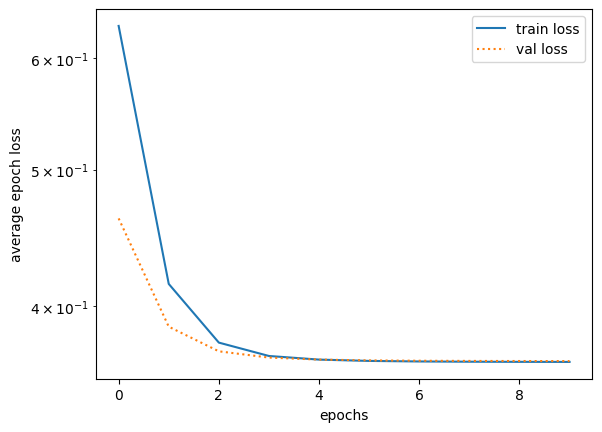

In [49]:
### let's check:
input_size=2
num_layers=1
hidden_size=[1]
simple_AE_model= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size)

avg_train_loss_simple_ae, avg_val_loss_simple_ae= train_and_validate_simple_AE(simple_AE_model,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae, avg_val_loss_simple_ae)

Epoch [1/10],Train Loss: 0.62417335 and  Validation Loss: 0.51084991
Epoch [2/10],Train Loss: 0.50361280 and  Validation Loss: 0.49770097
Epoch [3/10],Train Loss: 0.42317703 and  Validation Loss: 0.37765422
Epoch [4/10],Train Loss: 0.37170977 and  Validation Loss: 0.36867558
Epoch [5/10],Train Loss: 0.36674303 and  Validation Loss: 0.36629505
Epoch [6/10],Train Loss: 0.36537910 and  Validation Loss: 0.36566525
Epoch [7/10],Train Loss: 0.36503445 and  Validation Loss: 0.36547260
Epoch [8/10],Train Loss: 0.36485442 and  Validation Loss: 0.36528908
Epoch [9/10],Train Loss: 0.36467557 and  Validation Loss: 0.36510794
Epoch [10/10],Train Loss: 0.36451684 and  Validation Loss: 0.36496594


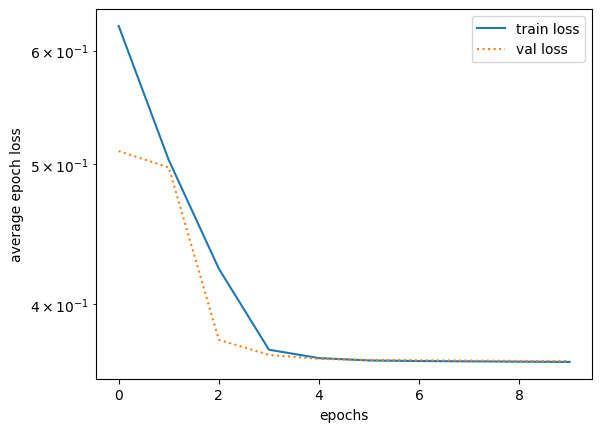

In [50]:
### let's check:
input_size=2
num_layers=2
hidden_size=[2,1]
simple_AE_model= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size)

avg_train_loss_simple_ae, avg_val_loss_simple_ae= train_and_validate_simple_AE(simple_AE_model,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae, avg_val_loss_simple_ae)

Epoch [1/10],Train Loss: 0.55465621 and  Validation Loss: 0.50003638
Epoch [2/10],Train Loss: 0.43764609 and  Validation Loss: 0.37515160
Epoch [3/10],Train Loss: 0.36961499 and  Validation Loss: 0.36680678
Epoch [4/10],Train Loss: 0.36560709 and  Validation Loss: 0.36567147
Epoch [5/10],Train Loss: 0.36477687 and  Validation Loss: 0.36496505
Epoch [6/10],Train Loss: 0.36432549 and  Validation Loss: 0.36478532
Epoch [7/10],Train Loss: 0.36425022 and  Validation Loss: 0.36475302
Epoch [8/10],Train Loss: 0.36422452 and  Validation Loss: 0.36473136
Epoch [9/10],Train Loss: 0.36420650 and  Validation Loss: 0.36471535
Epoch [10/10],Train Loss: 0.36419175 and  Validation Loss: 0.36470244


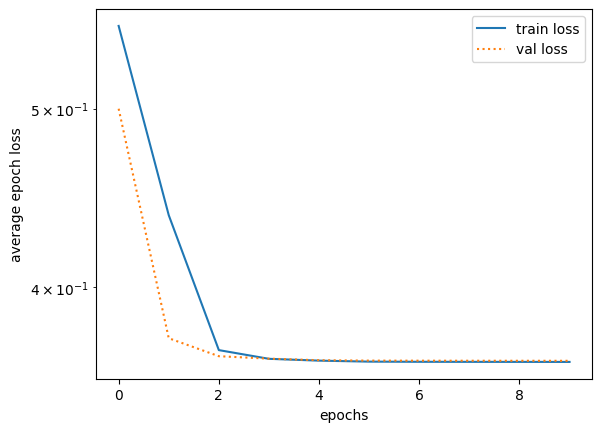

In [51]:
### let's check:
input_size=2
num_layers=2
hidden_size=[4,1]
simple_AE_model= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size)

avg_train_loss_simple_ae, avg_val_loss_simple_ae= train_and_validate_simple_AE(simple_AE_model,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae, avg_val_loss_simple_ae)

In [ ]:
### let's check:
input_size=2
num_layers=3
hidden_size_list=[2,2,1]
simple_AE_model_2= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size_list)

avg_train_loss_simple_ae2, avg_val_loss_simple_ae2= train_and_validate_simple_AE(simple_AE_model_2,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae2, avg_val_loss_simple_ae2)

In [ ]:
### let's check:
input_size=2
num_layers=3
hidden_size_list=[2,1,1]
simple_AE_model_2= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size_list)

avg_train_loss_simple_ae2, avg_val_loss_simple_ae2= train_and_validate_simple_AE(simple_AE_model_2,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae2, avg_val_loss_simple_ae2)

based on this, let's choose the architecture:

num_layers=2, hidden_size_list=[2,1]

Let's us now check for learning rate

In [ ]:
# Function to train and validate with different learning rates
def check_learning_rates(input_size, num_layers, hidden_size_list, learning_rates, num_epochs=10):
    losses_dict = {}

    for learning_rate in learning_rates:
        print(f"---------------learning rate is:{learning_rate}----------")

        # Create Autoencoder model
        simple_AE_model = Autoencoder(input_size=input_size, num_layers=num_layers,
                                      hidden_size=hidden_size_list)

        if learning_rate == 0.0001:
          num_epochs=40

        # Train and validate the model
        avg_train_loss, avg_val_loss = train_and_validate_simple_AE(
            simple_AE_model,
            cartesian_x_train_dataloader,
            cartesian_x_test_dataloader,
            num_epochs=num_epochs,
            learning_rate=learning_rate
        )

        # Store losses in dictionary
        losses_dict[f'Learning Rate={learning_rate}'] = (avg_train_loss, avg_val_loss)

    return losses_dict

# Hyperparameters
input_size = 2
num_layers = 2
hidden_size_list = [2, 1]
learning_rates = [1e-3, 5e-4, 1e-4]

# Check different learning rates
losses_dict = check_learning_rates(input_size, num_layers,
                                   hidden_size_list, learning_rates,
                                   num_epochs=10)

# Print the final losses for each learning rate
for config, (train_loss, val_loss) in losses_dict.items():
     print(f'Configuration: {config}, Final Train Loss: {train_loss[-1]:.8f}, Final Validation Loss: {val_loss[-1]:.8f}')

In [ ]:
def plot_losses(losses_dict):
    plt.figure(figsize=(10, 6))

    for config, (train_loss, val_loss) in losses_dict.items():
        epochs = range(1, len(train_loss) + 1)
        plt.plot(epochs, train_loss, label=f'Train Loss ({config})')
        plt.plot(epochs, val_loss, label=f'Validation Loss ({config})', linestyle='dashed')

    plt.title('Train and Validation Loss for Different Learning Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Plot losses for different learning rate cases together
plot_losses(losses_dict)

Based on this test, we chose the learning rate to be: 0.001

2.3 Propagation of Time Derivatives:

In [ ]:
# import torch
# import torch.nn as nn

# class SigmoidDerivatives(nn.Module):
#     def dg(self, z_tilde_l):
#         return torch.sigmoid(z_tilde_l) * (1 - torch.sigmoid(z_tilde_l))

#     def ddg(self, z_tilde_l):
#         return self.dg(z_tilde_l) * (1 - 2 * torch.sigmoid(z_tilde_l))

#     def forward(self, z_tilde_l, dz_tilde_l, ddz_tilde_l):
#         z_l = torch.sigmoid(z_tilde_l)
#         dz_l = self.dg(z_tilde_l) * dz_tilde_l
#         ddz_l = (self.ddg(z_tilde_l) * dz_tilde_l) * dz_tilde_l + self.dg(z_tilde_l) * ddz_tilde_l
#         return z_l, dz_l, ddz_l

# class LinearDerivatives(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(LinearDerivatives, self).__init__()
#         self.linear = nn.Linear(in_features, out_features)

#     def forward(self, z_l, dz_l, ddz_l, include_bias=True):
#         # Include bias for z_tilde_l
#         z_tilde_l = self.linear(z_l)

#         # Exclude bias for derivatives
#         if include_bias:
#             dz_tilde_l = self.linear(dz_l)
#             ddz_tilde_l = self.linear(ddz_l)
#         else:
#             dz_tilde_l = self.linear(dz_l) - self.linear.bias
#             ddz_tilde_l = self.linear(ddz_l) - self.linear.bias

#         return z_tilde_l, dz_tilde_l, ddz_tilde_l

# class CustomAutoencoder(nn.Module):
#     def __init__(self, input_size, num_layers, hidden_size):
#         super(CustomAutoencoder, self).__init__()

#         # encoder layers
#         layers = []
#         for i in range(num_layers):
#             layers.append(LinearDerivatives(input_size, hidden_size[i]))
#             layers.append(SigmoidDerivatives())
#         self.encoder = nn.Sequential(*layers)

#         # Decoder layers
#         layers = []
#         for i in range(num_layers - 1, 0, -1):
#             layers.append(LinearDerivatives(hidden_size[i], input_size))
#             layers.append(SigmoidDerivatives())
#         self.decoder = nn.Sequential(*layers)

#     def forward(self, x, dx, ddx):
#         ### encoding part
#         z_l, dz_l, ddz_l = x, dx, ddx #initialising
#         for layer in self.encoder:
#             if isinstance(layer, LinearDerivatives):
#                 z_tilde_l, dz_tilde_l, ddz_tilde_l = layer(z_l, dz_l, ddz_l, include_bias=False)
#             elif isinstance(layer, SigmoidDerivatives):
#                 z_l, dz_l, ddz_l = layer(z_tilde_l, dz_tilde_l, ddz_tilde_l)

#         ## after L such layers z_L= z, dz_L= dz and ddz_L=ddz

#         # decoder part
#         for layer in self.decoder:
#             if isinstance(layer, LinearDerivatives):
#                 x_tilde_l, dx_tilde_l, ddx_tilde_l = layer(z_l, dz_l, ddz_l, include_bias=False)
#             elif isinstance(layer, SigmoidDerivatives):
#                 x_l, dx_l, ddx_l = layer(x_tilde_l, dx_tilde_l, ddx_tilde_l)

#         # The final output should be the reconstructed Cartesian coordinates
#         reconstructed_x = x_l.clone()
#         reconstructed_dx = dz_l.clone()
#         reconstructed_ddx = ddz_l.clone()

#         return reconstructed_x, reconstructed_dx, reconstructed_ddx, z_l, dz_l, ddz_l

In [163]:
### more clean code

import torch
import torch.nn as nn

class SigmoidDerivatives(nn.Module):
    def dg(self, z_in):
        return torch.sigmoid(z_in) * (1 - torch.sigmoid(z_in))

    def ddg(self, z_in):
        return self.dg(z_in) * (1 - 2 * torch.sigmoid(z_in))

    def forward(self, z_tilde_l, dz_tilde_l, ddz_tilde_l):
        z_l = torch.sigmoid(z_tilde_l)
        dz_l = self.dg(z_tilde_l) * dz_tilde_l
        ddz_l = (self.ddg(z_tilde_l) * dz_tilde_l) * dz_tilde_l + self.dg(z_tilde_l) * ddz_tilde_l
        return z_l, dz_l, ddz_l

class LinearDerivatives(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearDerivatives, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, z_l, dz_l, ddz_l, include_bias=True):
        # Include bias for z_tilde_l
        z_tilde_l = self.linear(z_l)

        # Exclude bias for derivatives
        if include_bias:
            dz_tilde_l = self.linear(dz_l)
            ddz_tilde_l = self.linear(ddz_l)
        else:
            dz_tilde_l = self.linear(dz_l) - self.linear.bias
            ddz_tilde_l = self.linear(ddz_l) - self.linear.bias

        return z_tilde_l, dz_tilde_l, ddz_tilde_l

class Encoder(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size):
        super(Encoder, self).__init__()

        layers = []
        for i in range(num_layers):
            layers.append(LinearDerivatives(input_size, hidden_size[i]))
            layers.append(SigmoidDerivatives())
        self.encoder = nn.Sequential(*layers)

    def forward(self, x, dx, ddx):
        z_l, dz_l, ddz_l = x.clone(), dx.clone(), ddx.clone()  # initializing
        for layer in self.encoder:
            if isinstance(layer, LinearDerivatives):
                z_tilde_l, dz_tilde_l, ddz_tilde_l = layer(z_l, dz_l, ddz_l, include_bias=False)
            elif isinstance(layer, SigmoidDerivatives):
                z_l, dz_l, ddz_l = layer(z_tilde_l, dz_tilde_l, ddz_tilde_l)

        return z_l, dz_l, ddz_l

class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size, output_size):
        super(Decoder, self).__init__()

        layers = []
        for i in range(num_layers - 1, 0, -1):
            layers.append(LinearDerivatives(hidden_size[i], output_size))
            layers.append(SigmoidDerivatives())
        self.decoder = nn.Sequential(*layers)

    def forward(self, z_l, dz_l, ddz_l):
        # decoder part
        x_l, dx_l, ddx_l = z_l.clone(), dz_l.clone(), ddz_l.clone()
        for layer in self.decoder:
            if isinstance(layer, LinearDerivatives):
                x_tilde_l, dx_tilde_l, ddx_tilde_l = layer(x_l, dx_l, ddx_l, include_bias=False)
            elif isinstance(layer, SigmoidDerivatives):
                x_l, dx_l, ddx_l = layer(x_tilde_l, dx_tilde_l, ddx_tilde_l)

        # The final output should be the reconstructed Cartesian coordinates
        reconstructed_x = x_l.clone()
        reconstructed_dx = dz_l.clone()
        reconstructed_ddx = ddz_l.clone()

        return reconstructed_x, reconstructed_dx, reconstructed_ddx

class CustomAutoencoder(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size):
        super(CustomAutoencoder, self).__init__()

        self.encoder = Encoder(input_size, num_layers, hidden_size)
        self.decoder = Decoder(num_layers, hidden_size, input_size)

    def forward(self, x, dx, ddx):
        z_l, dz_l, ddz_l = self.encoder(x, dx, ddx)

        reconstructed_x, reconstructed_dx, reconstructed_ddx = self.decoder(z_l, dz_l, ddz_l)

        return reconstructed_x, reconstructed_dx, reconstructed_ddx, z_l, dz_l, ddz_l


Let's verify our implementation by comparing the propagated time derivatives with the discrete first and second order derivatives:

Creating the required data and dataloaders

In [164]:
z_diff_init_cond= np.concatenate(z_arrays, axis=1)
dzdt_diff_init_cond= np.concatenate(dzdt_arrays, axis=1)
d2zdt_diff_init_cond= np.concatenate(d2zdt_arrays, axis=1)
# print(z_diff_init_cond);
print(z_diff_init_cond.shape)

(2500, 100)


In [189]:
x_1, xdot_1,xddot_1= cartesian_embedding(z_diff_init_cond[:,0][:,np.newaxis],
                                   dzdt_diff_init_cond[:,0][:,np.newaxis],
                                   d2zdt_diff_init_cond[:,0][:,np.newaxis])
x_1.shape, xdot_1.shape, xddot_1.shape

((2500, 2), (2500, 2), (2500, 2))

In [195]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

#
class CustomDataset_modified_AE(Dataset):
    def __init__(self, data_x1, data_x2, data_x3):
        self.data_x1 = data_x1
        self.data_x2 = data_x2
        self.data_x3 = data_x3

    def __len__(self):
        # all components have the same length
        return len(self.data_x1)

    def __getitem__(self, idx):
        sample_x1 = self.data_x1[idx]
        sample_x2 = self.data_x2[idx]
        sample_x3 = self.data_x3[idx]

        return sample_x1, sample_x2, sample_x3

In [244]:
# Split the dataset into train and test sets
cart_x1_train, cart_x1_test = train_test_split(x_1, test_size=0.5,shuffle=False)
cart_x1dot_train, cart_x1dot_test = train_test_split(xdot_1, test_size=0.5, shuffle=False)
cart_x1ddot_train, cart_x1ddot_test = train_test_split(xddot_1, test_size=0.5, shuffle=False)

# Convert numpy arrays to PyTorch tensors
cart_x1_train_tensor = torch.Tensor(cart_x1_train)
cart_x1_test_tensor = torch.Tensor(cart_x1_test)
cart_x1dot_train_tensor = torch.Tensor(cart_x1dot_train)
cart_x1dot_test_tensor = torch.Tensor(cart_x1dot_test)
cart_x1ddot_train_tensor = torch.Tensor(cart_x1ddot_train)
cart_x1ddot_test_tensor = torch.Tensor(cart_x1ddot_test)

# Create custom datasets and dataloaders
batch_size = np.shape(cart_x1_train)[0]

# Training dataset and dataloader
train_dataset1 = CustomDataset_modified_AE(cart_x1_train_tensor, cart_x1dot_train_tensor,cart_x1ddot_train_tensor )
cartesian_x1_train_dataloader = DataLoader(train_dataset1, batch_size=batch_size, shuffle=False)


# Testing dataset and dataloader
test_dataset1 = CustomDataset_modified_AE(cart_x1_test_tensor, cart_x1dot_test_tensor,cart_x1ddot_test_tensor)
cartesian_x1_test_dataloader = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)


cart_x1_train_tensor:
tensor([[-0.5871, -0.8095],
        [-0.6075, -0.7943],
        [-0.6272, -0.7788],
        ...,
        [-0.6955, -0.7185],
        [-0.6779, -0.7351],
        [-0.6598, -0.7515]])


In [250]:
# Function to compute discrete derivatives
def compute_discrete_derivatives(z_values):
    dz = (z_values[2:] - z_values[:-2]) / (2 * delta_t)
    ddz = (z_values[:-2] - 2 * z_values[1:-1] + z_values[2:]) / (delta_t ** 2)
    return dz, ddz

# Verify the implementation
def verify(encoder, dataloader):
    encoder.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            x, dx, ddx = batch

            z, dz, ddz = encoder(x, dx, ddx)

            # Convert z to numpy for computing discrete derivatives
            z_values = z.cpu().numpy()

            # Compute discrete derivatives
            discrete_dz, discrete_ddz = compute_discrete_derivatives(z_values)

            # Compare the predicted derivatives with discrete derivatives
        return z, dz, ddz, discrete_dz, discrete_ddz

In [258]:
# Use the verify function with your encoder and dataloader
delta_t = 0.02
input_size=2
num_layers=1
hidden_size_list=[1]

custom_ae_model = CustomAutoencoder(input_size, num_layers, hidden_size= hidden_size_list)
# Extract the encoder part from the model
encoder_instance = custom_ae_model.encoder


z_out, dz_out, ddz_out, discrete_dz_out, discrete_ddz_out= verify(encoder_instance, cartesian_x1_train_dataloader)


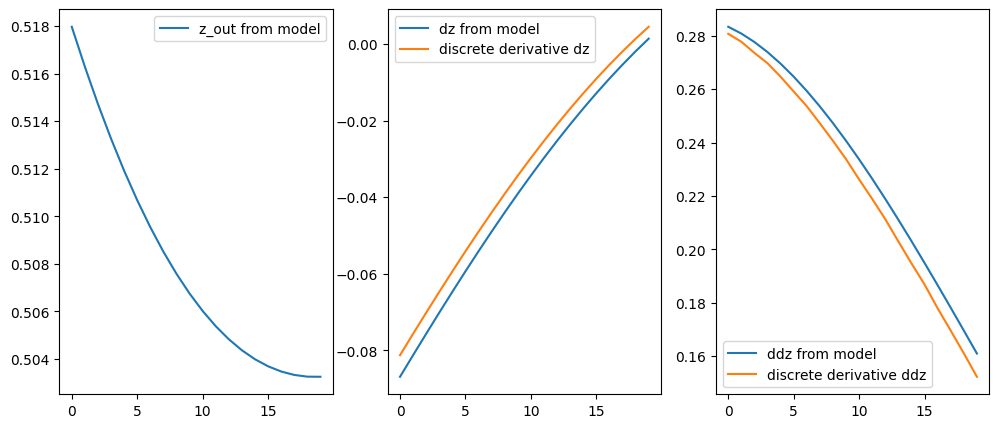

In [259]:
# time=np.arange(0,T/2,step=delta_t)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(z_out[:20], label="z_out from model")
plt.legend()
plt.subplot(1,3,2)
plt.plot(dz_out[:20], label="dz from model")
plt.plot(discrete_dz_out[:20], label="discrete derivative dz")
plt.legend()
plt.subplot(1,3,3)
plt.plot(ddz_out[:20], label="ddz from model")
plt.plot(discrete_ddz_out[:20], label="discrete derivative ddz")
plt.legend()



As can be seen from the plots above, derivatives obtained from the model (propagated time derivatives) match quite well with the discrete derivatives, hinting that our implementation is indeed correct :) !

2.4 Implementing `SINDyAutoencoder`:

# Everything below is not important

In [186]:
# import numpy as np
# from scipy.integrate import odeint
# import matplotlib.pyplot as plt

# # Define the ODE system
# def my_ode(y, t):
#     dydt = -2 * y  # Example: simple exponential decay
#     return dydt

# # Initial condition
# y0 = 1.0

# # Time points
# t = np.linspace(0, 5, 101)

# # Solve the ODE using odeint
# solution = odeint(my_ode, y0, t)

# # Plot the solution
# plt.plot(t, solution)
# plt.xlabel('Time')
# plt.ylabel('y(t)')
# plt.title('ODE Solution')
# plt.show()
